In [19]:
## Loading MNIST dataset from keras
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import time
import random
 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


In [20]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    # normalize
    X_train = X_train/255
    X_test = X_test/255
    X_test, y_test = shuffle(X_test, y_test)
    
    # we reserve the last 10000 training examples for validation
    X_val, X_test  = X_test[:-5000], X_test[-5000:]
    y_val, y_test  = y_test[:-5000], y_test[-5000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()


In [21]:
## Changing dimension of input images from N*28*28 to  N*784
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]))

## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)


In [36]:
## Defining various initialization parameters for MLP model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]

neurons_layers1 = 512

neurons_hidden_layers=[20]

num_hidden_layers =len(neurons_hidden_layers)
#total de layer is num_hidden_layers+2  

#last layer in this application, there is never dropout
dropout_layers= np.zeros(num_hidden_layers+1)

# l1 and l2 can be applied to any layer
l1 =np.zeros(num_hidden_layers+2) 
l2 =np.zeros(num_hidden_layers+2)

dropout_layers[1]=1
#first  layer with L2, fourth layer there is l1  
l1[2]=1
l2[0]=1

#dropout 40%
taxa=0.4

neurons_last_layer =num_output

cost_function ='mse'
op_otimizador='gd'

learning_rate = 0.005
regularizer_rate = 0.01
dropout_prob = 0.4
# Placeholders for the input data
input_X = tf.placeholder('float32',shape =(None,num_features),name="input_X")
input_y = tf.placeholder('float32',shape = (None,num_classes),name='input_Y')

In [37]:
def first_layer(neurons_input,neurons_output,inputs, dropout,activation_func):
    
    weights.append(tf.Variable(tf.random_normal([neurons_input,neurons_output], stddev=(1/tf.sqrt(float(neurons_input))))))
    bias.append(tf.Variable(tf.random_normal([neurons_output])))
    
    if(activation_func=='relu'):
        visible_layer =tf.nn.relu(tf.matmul(inputs,weights[-1])+bias[-1])
    
    if(dropout):
        visible_layer= (tf.nn.dropout(visible_layer, rate=taxa))
    
    return visible_layer
  
def hdd_layer(neurons_input=0, neurons_output=0, dropout=False, previous_layer=0, activation_func=None) :
    weights.append(tf.Variable(tf.random_normal([neurons_input,neurons_output], stddev=(1/tf.sqrt(float(neurons_input))))))
    bias.append(tf.Variable(tf.random_normal([neurons_output])))

    if(activation_func=='relu'):
        hidden_output =tf.nn.relu(tf.matmul(previous_layer,weights[-1])+bias[-1])
    
    if(dropout):
        hidden_output= (tf.nn.dropout(hidden_output, rate=taxa))
    return hidden_output

  
def last_layer(activation_func,neurons_input,neurons_output,previous_layer):
    weights.append(tf.Variable(tf.random_normal([neurons_input,neurons_output], name="W", 
                                                stddev=(1/tf.sqrt(float(neurons_input)))
                                                )))
    bias.append(tf.Variable(tf.random_normal([neurons_output]), name="B"))
    
    if(activation_func=='sigmoid'):
        predicted_y = tf.sigmoid(tf.matmul(previous_layer,weights[-1]) + bias[-1])
    elif(activation_func=='softmax'):
        predicted_y = tf.nn.softmax(tf.matmul(previous_layer,weights[-1]) + bias[-1])
    elif(activation_func=='tanh'):
        predicted_y=tf.nn.tanh(tf.matmul(previous_layer,weights[-1]) + bias[-1])
    return predicted_y

In [38]:
control = tf.constant([0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001])
def perda(op_cost,L1,L2):
    if (op_cost=='cross entropy'):       
        xent = -input_y*tf.log(tf.add(control,tf.abs(predicted_y))) - (1-input_y)*tf.log(tf.add(control,tf.abs((1-predicted_y)))) # Cross-entropy
        cost = tf.reduce_mean(xent)
    elif(op_cost=='mse'):
        mse = tf.square((predicted_y -input_y))
        cost = tf.reduce_sum(mse)
    elif(op_cost=='scewl'):
        cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y))
     
    for (index,value) in enumerate(L1):
        if(value==1):
            cost+=regularizer_rate*(tf.reduce_sum(tf.abs(weights[index])) +tf.reduce_sum(tf.abs(bias[index])))

    for (index,value) in enumerate(L2):
        if(value==1):
            cost+=regularizer_rate*(tf.reduce_sum(weights[index]**2)+tf.reduce_sum(bias[index]**2))
  
    return cost

def otimizador(loss,op):
    #learning_rate = tf.train.exponential_decay(learning_rate_start, 0, 5, 0.85, staircase=True)
    if(op=='gd'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[weights,bias])
    elif(op=='adam'): 
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=[weights,bias])
  
    return optimizer

In [39]:
## Here we call the functions to define layers, loss and optimezer
weights=[]
bias =[]

layers_outupt=first_layer(neurons_input=num_features,neurons_output=neurons_layers1,dropout=dropout_layers[0],inputs=input_X, activation_func='relu')

neurons_layer_before = neurons_layers1

for neurons_hdd, op_drop in zip(neurons_hidden_layers,dropout_layers[1:]):  
    layers_outupt=hdd_layer(neurons_input=neurons_layer_before,neurons_output=neurons_hdd,dropout=op_drop,previous_layer=layers_outupt,activation_func='relu')
    neurons_layer_before = neurons_hdd

predicted_y =last_layer(neurons_input=neurons_layer_before,neurons_output=num_classes,previous_layer=layers_outupt,activation_func='softmax')

#p_y_given_x = tf.softmax(tf.tensordot(input_y, weights[-1] + bias[-1],0))

cost=perda(cost_function,l1,l2)
optimizer=otimizador(cost,op_otimizador)

## Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [40]:
def plot_confusion_matrix(test_accuracy,y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusão. Acurácia global: '+str(test_accuracy)
        else:
            title = 'Matriz de confusão. Acurácia global: '+str(test_accuracy)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Epoch:0, Train loss: 22164.34 Train acc: 0.717, Validação acc:0.726
Treinamento finalizado. Tempo decorrido:  0.19724705616633098 min 

Resultado com o teste
Test acc: 0.7296


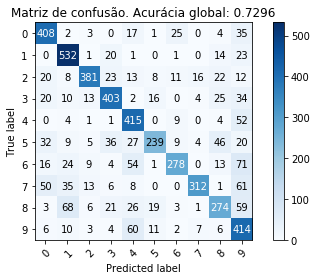

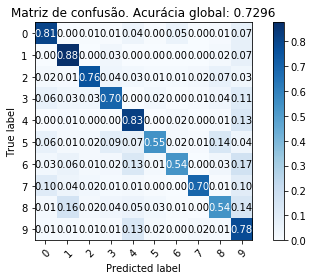

In [41]:
## Training parameters
class_name=[]
for i in range(10):
    class_name.append(str(i))
    
training_accuracy = []
training_loss = []
validation_accuracy = []
batch_size = 32
epochs=1

# Initialization
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    start = time.time()

    for epoch in range(epochs):    
        arr = np.arange(X_train.shape[0])
        np.random.shuffle(arr)

        for index in range(0,X_train.shape[0],batch_size):
            session.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],input_y: y_train[arr[index:index+batch_size]]})
        
        training_accuracy.append(session.run(accuracy, feed_dict= {input_X:X_train,input_y: y_train}))
        training_loss.append(session.run(cost, {input_X: X_train,input_y: y_train}))        
        ## Evaluation of model
        validation_accuracy.append(accuracy_score(y_val.argmax(1),session.run(predicted_y, {input_X: X_val}).argmax(1)))
        
        print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Validação acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                    validation_accuracy[epoch]))
        
    end = time.time()
    print('Treinamento finalizado. Tempo decorrido: ',(end-start)/60,'min \n')
    print('Resultado com o teste')
    test_accuracy= accuracy_score(y_test.argmax(1), session.run(predicted_y, {input_X: X_test}).argmax(1))
    
    print("Test acc:",test_accuracy)
    
        
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(test_accuracy,y_test.argmax(1), session.run(predicted_y, {input_X: X_test}).argmax(1), classes=class_name)

    # Plot normalized confusion matrix
    plot_confusion_matrix(test_accuracy,y_test.argmax(1), session.run(predicted_y, {input_X: X_test}).argmax(1), classes=class_name, normalize=True)

    plt.show()